# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [10]:
filtroParaElSubsetDeDatos = "Capital Federal"

In [11]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, "Capital Federal")

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28666 entries, 0 to 109291
Data columns (total 14 columns):
property_type                28666 non-null object
place_name                   28666 non-null object
price                        28666 non-null float64
surface_covered_in_m2        28666 non-null float64
surface_not_covered_in_m2    28666 non-null float64
price_usd_per_m2             28666 non-null float64
rooms                        28666 non-null float64
lat_mediaPorZona             28666 non-null float64
lon_mediaPorZona             28666 non-null float64
pileta                       28666 non-null int64
cochera                      28666 non-null int64
balcon                       28666 non-null int64
terraza                      28666 non-null int64
parrilla                     28666 non-null int64
dtypes: float64(7), int64(5), object(2)
memory usage: 3.3+ MB
None



Sub data frame Head: 

  property_type place_name     price  surface_covered_in_m

# Analizamos outliers y los sacamos del data frame

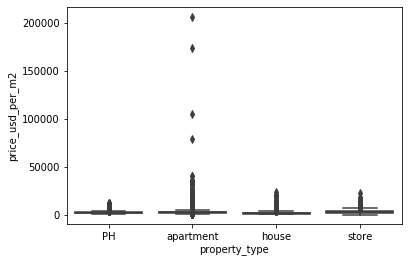

In [12]:
sns.boxplot('property_type','price_usd_per_m2', data=df_subset)


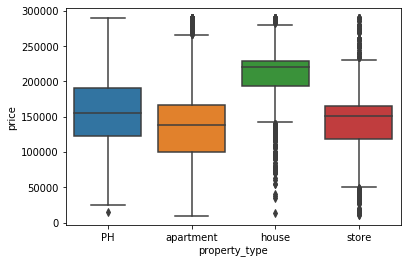

In [13]:
sns.boxplot('property_type','price', data=df_subset)

# Analizamos las variables categóricas

palermo                2682
belgrano               2590
recoleta               2464
caballito              2054
villa urquiza          1358
flores                 1250
balvanera              1189
villa crespo           1176
almagro                1010
capital federal         964
san telmo               958
boedo                   835
nuñez                   687
san cristobal           594
puerto madero           568
san nicolás             494
saavedra                486
floresta                454
villa del parque        449
palermo hollywood       443
monserrat               416
mataderos               404
villa devoto            398
barracas                396
villa luro              396
liniers                 377
colegiales              327
parque patricios        313
palermo soho            300
retiro                  240
coghlan                 227
palermo chico           220
chacarita               205
constitución            199
villa lugano            184
boca                

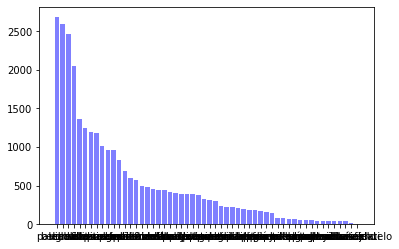

apartment    23656
house         2022
PH            1747
store         1241
Name: property_type, dtype: int64


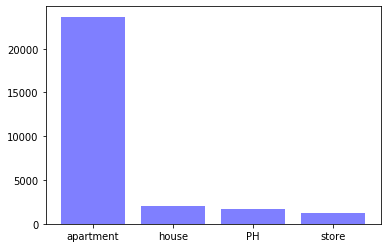

In [14]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [15]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [16]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,PH,mataderos,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,0,0,0
2,apartment,mataderos,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,1,0,0
3,PH,liniers,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,...,0,0,0,0,0,0,0,0,0,0
7,apartment,belgrano,138000.0,40.000000,5.0,3066.666667,1.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0
8,apartment,belgrano,195000.0,60.000000,5.0,3000.000000,2.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [17]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_almagro,place_name_balvanera,place_name_barracas,place_name_belgrano,place_name_boca,place_name_boedo,place_name_caballito,place_name_capital federal,place_name_chacarita,...,place_name_villa general mitre,place_name_villa lugano,place_name_villa luro,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza
0,mataderos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,liniers,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,belgrano,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,palermo soho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,palermo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,flores,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,boedo,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,puerto madero,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,balvanera,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,caballito,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [18]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,PH,0,0,0
2,apartment,1,0,0
46,house,0,1,0
55,store,0,0,1


# Generamos el objeto para el K Fold

In [19]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [20]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,40.000000,5.0,3066.666667,1.0,-34.563566,-58.453991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,60.000000,5.0,3000.000000,2.0,-34.563566,-58.453991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109238,65.000000,26.0,1813.186813,4.0,-34.592516,-58.397354,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
109241,39.000000,5.0,3750.000000,1.0,-34.592516,-58.397354,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
109283,157.000000,0.0,999.044328,3.0,-34.563566,-58.453991,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
109289,93.000000,20.0,7699.115044,4.0,-34.563566,-58.453991,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


# Generamos un modelo con Regresion Lineal

In [21]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [22]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

### Realizamos un entrenamiento de una sola pasada, para ver que nos devuelve

In [23]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal sin k-fold: [ -5429520.04749105  -6474361.24943784 -14627880.66578493
 -10670075.95228788  -5560488.95301183]



Intercept: 
3252.514867550773



Coeficientes: 
[-3.13044582e+02 -2.58441505e+02  4.48984490e+01 -1.36939786e+15
 -1.60201620e+15  9.09383392e+00  3.20490600e+01 -3.17836873e+01
 -2.23417065e+01  4.32687500e+02  3.66754050e+14  5.51010058e+14
  3.04379941e+14  7.47630901e+14  2.60059746e+14  2.33343294e+14
  1.62980626e+14  1.70156742e+14  1.30093326e+14  1.60457755e+14
  2.15301093e+14 -9.63354671e+13 -1.38906900e+14 -2.09623864e+14
 -4.03712670e+14 -5.49600236e+14  3.82767796e+14 -1.07110956e+14
 -3.21678486e+14  4.35609818e+14  8.61676504e+14  3.25819343e+14
  3.21779955e+14  2.72907518e+14  1.09027468e+14 -8.68745950e+13
  7.34836894e+13  8.13500653e+12  1.83613958e+13  1.55132671e+14
  2.48553361e+13  5.76516386e+14  1.02743334e+15  3.91901613e+14
  2.47962414e+14  3.06855199e+14  4.87341089e+14  5.96024335e+14
 -7.12622796e+13 -1.34432853e+14  3.

In [24]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
69178,2205.882353,3124.978365,-919.096012
24758,17495.666667,10620.963986,6874.702681
19439,2089.743590,2600.573361,-510.829771
100238,2794.117647,3238.963986,-444.846339
24450,1230.000000,10645.713986,-9415.713986
...,...,...,...
42650,2392.405063,3433.713986,-1041.308923
23287,2172.727273,2643.338986,-470.611713
49153,1900.000000,2432.713986,-532.713986
48067,2288.135593,2106.112423,182.023170


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [25]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [26]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(4,10,500), cv)

Score Ridge CV: 0.32520505211458206
Alpha Ridge CV: 10.0
Coeficientes:  [-3.04720341e+02 -2.57794452e+02  4.01448330e+01  9.89453348e+00
  3.40983995e+02  3.22262512e+00  4.17626848e+01 -3.67208497e+01
 -2.26707529e+01  4.25114707e+02 -3.71429526e+01 -1.63561471e+02
 -1.18368908e+02  1.47920496e+02 -8.96284569e+01  1.05599729e+03
 -4.83131474e+01 -1.19166331e+02 -3.04068467e+01 -2.16704465e+00
 -1.03288085e+01 -1.41897943e+02 -4.06832091e+01 -1.79416692e+01
 -3.04747307e-01  1.07498884e+01 -1.27203964e+02  3.44258888e+01
 -5.13752812e+01  8.83902388e+01  1.06345224e+02  1.24380646e+02
  3.66156703e+01  3.68099421e+01  1.28016415e+01 -1.06137147e+01
 -1.57531580e+01 -1.16700331e+01 -1.06188199e+01 -8.48488968e+01
 -2.29016741e+01  2.84696931e+02  6.04694536e+01 -2.33960659e+01
  2.52352882e+01  6.40933111e+02 -9.31189822e+01 -1.89102835e+02
  8.85708470e-01  1.69690426e+01 -3.16564694e+01  3.54553197e+01
  6.31900647e+01 -1.49234178e+01 -3.10808303e+01  2.29001625e+01
 -1.15435718e+01  

In [27]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
69178,2205.882353,3154.406022,-948.523669
24758,17495.666667,10593.380395,6902.286271
19439,2089.743590,2611.813565,-522.069975
100238,2794.117647,3254.878404,-460.760757
24450,1230.000000,10602.183108,-9372.183108
...,...,...,...
98147,2412.280702,2280.669225,131.611477
95429,2600.000000,2087.167594,512.832406
42499,2911.392405,3016.331877,-104.939472
10540,2298.387097,3567.912968,-1269.525872


# Generamos el modelo para Lasso Cross Validation

In [28]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



2874.1081749297864



Coeficientes: 



[-2.97396904e+02 -2.56262411e+02  3.23054056e+01  1.89899268e+02
  2.12267729e+01  2.74232694e+00  3.85466139e+01 -3.38066545e+01
 -2.07869041e+01  4.22601729e+02  2.97282565e+01 -4.72556401e+01
 -6.93851595e+00  1.02343655e+02 -8.20392497e+00  1.14101990e+03
  1.58778556e+01 -5.96359859e+01 -2.84099243e+01 -2.75126878e+01
 -1.26495019e+01 -0.00000000e+00 -9.59993571e+00 -1.99638988e+01
 -2.29423144e+01 -0.00000000e+00 -3.89469478e+01  1.88586651e+01
  5.78448078e+01  3.79602935e+01  1.61130333e+02  1.47690656e+02
  4.83516956e+01  5.96787267e+01  2.21318513e+01 -2.81039636e+00
 -1.45621096e+00  1.43894298e+01 -1.81239147e+01 -1.23019754e+01
 -2.16574759e+01  4.04528393e+02  1.94014333e+02  3.39040714e+01
 -3.23461481e+01  7.26724553e+02 -3.04258349e+00 -3.65148482e+01
 -3.03022843e-01  0.00000000e+00  0.00000000e+00  1.09514286e+01
  1.58756109e+01 -1.28883799e+01 -3.12186019e+00  5.05529004e+00
 -1.74311831e+01 -1.28177457e+01

In [29]:

df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
69178,2205.882353,3125.669523,-919.787170
24758,17495.666667,10580.487439,6915.179228
19439,2089.743590,2598.529791,-508.786201
100238,2794.117647,3248.658476,-454.540828
24450,1230.000000,10587.978201,-9357.978201
...,...,...,...
98147,2412.280702,2290.518746,121.761956
95429,2600.000000,2067.780393,532.219607
42499,2911.392405,3011.271262,-99.878857
10540,2298.387097,3561.970567,-1263.583470


# Verificamos los resultados

In [30]:
#de los 3 modelos analizar el mejor
#con ridge y lasso, analizar con que coeficientes se queda

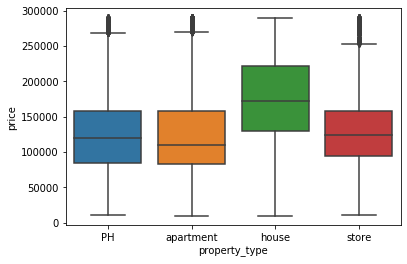

In [31]:
sns.boxplot('property_type','price', data=df)


In [32]:
print(" Score Train Lineal: %.2f\n" % regresionLineal_model.score(X_train, y_train),
      "Score Train Ridge : %.2f\n" % model_ridge.score(X_train, y_train),
      "Score Train Lasso : %.2f\n" %  model_lasso.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lm = regresionLineal_model.predict(X_train)
y_pred_tr_ridge = model_ridge.predict(X_train)
y_pred_tr_lasso =model_lasso.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(metrics.mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm),
      "Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge),
      "Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))


 Score Train Lineal: -1678368881165644964114202624.00
 Score Train Ridge : -159.06
 Score Train Lasso : -80.86

 Train RMSE lineal   : 141378331701084768.00 
 Train RMSE Ridge    : 43659.29 
 Train RMSE Lasso    : 31223.29 

